# Image Classification with Convolutional Neural Networks in Keras
## Computer Vision and Image Processing - Lab Session 6 Excercises
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Alex Costanzino, alex.costanzino@unibo.it - Iacopo Curti, iacopo.curti2@unibo.it

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# import torch
# Verifica se PyTorch vede la GPU
# gpu_available = torch.cuda.is_available()
# print("GPU disponibile:", gpu_available)
# if gpu_available:
#     print("Nome GPU:", torch.cuda.get_device_name(0))
#     print("Numero di GPU:", torch.cuda.device_count())


# Select the CPU and TensorFlow's backend.
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # commenta se vuoi usare la gpu

os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)
# Fixed random seed for repeatability.

seed = 42
keras.utils.set_random_seed(seed)
np.random.seed(seed)

import warnings
warnings.filterwarnings("ignore")


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

2025-12-13 14:03:26.860410: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-13 14:03:27.258614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-13 14:03:29.380159: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


3.12.0


## Exercise 1: Data normalization

Try to reimplement the code explained in the theory. Load the data, inspect it and train a new classifier without performing data normalization, keeping the same parameters of the original experiment.
* Are there any differences in terms of performances?
    - senza normalizzazione si hanno delle performance leggermente peggiori
    - la rete poi sembra imparare molto a scatti e non in maniera controllata
* How does normalization affect the training time?
    - non ho notato grandi differenza ma ho eseguito solo su gpu

Con dataset più grandi forse si noterebbero delle differenze più sostanziali

In [4]:
### carichiamo il dataset

from keras.datasets import fashion_mnist

labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(f"The images are in the range [{np.min(x_train)},{np.max(x_train)}].")
n_train, w_train, h_train = x_train.shape
n_test, w_test, h_test = x_test.shape
unique_labels = np.unique(y_train)
n_classes = len(unique_labels)

# aggiungiamo la depth dell'immagine (assente per immagini grayscale)
if x_train.shape[-1] != 1:
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
print(f"The new shape of the feature matrix is: {x_train.shape}.")

# non normalizziamo i dati
# x_train = x_train.astype('float') / np.max(x_train)
# x_test = x_test.astype('float') / np.max(x_test)
# print(f"The new range of the images is [{x_train.min()},{x_train.max()}].")

The images are in the range [0,255].
The new shape of the feature matrix is: (60000, 28, 28, 1).


In [5]:
### definiamo il modello

from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

input_shape = x_train.shape[1:]
print(f"The input shape of the CNN is {input_shape}.")

model = Sequential(
    [   
        # Input layer.
        Input(shape = input_shape),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes, activation = "softmax")
    ]
)
model.summary()

The input shape of the CNN is (28, 28, 1).


2025-12-13 14:03:33.263525: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,186 (196.04 KB)

 Trainable params: 50,186 (196.04 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
### facciamo il training del modello

from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
model.compile(loss = loss_fcn,
              optimizer = opt, 
              metrics = ["accuracy"]) 

batch_size = 128
epochs = 8
val_split_percentage = 0.25
model.fit(x_train, 
          y_train, 
          batch_size = batch_size, 
          epochs = epochs, 
          validation_split = val_split_percentage);

Epoch 1/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8077 - loss: 0.9121 - val_accuracy: 0.8633 - val_loss: 0.3879
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8830 - loss: 0.3349 - val_accuracy: 0.8857 - val_loss: 0.3277
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9001 - loss: 0.2808 - val_accuracy: 0.8903 - val_loss: 0.3086
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9115 - loss: 0.2477 - val_accuracy: 0.8921 - val_loss: 0.3054
Epoch 5/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.9179 - loss: 0.2287 - val_accuracy: 0.8939 - val_loss: 0.3075
Epoch 6/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9236 - loss: 0.2144 - val_accuracy: 0.8953 - val_loss: 0.3099
Epoch 7/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9267 - loss: 0.2006 - val_accuracy: 0.8949 - val_loss: 0.3143
Epoch 8/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.9312 - loss: 0.1893 - val_accu

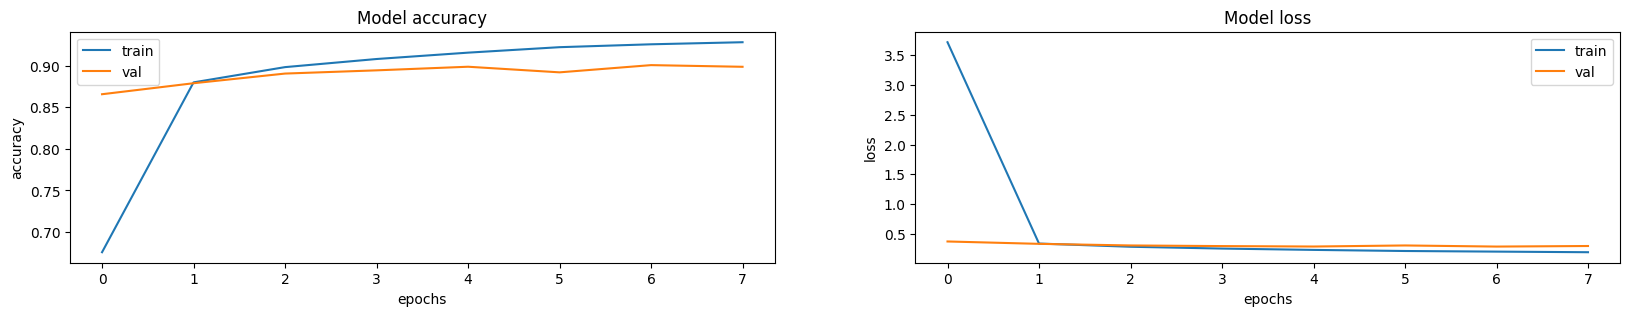

In [40]:
### valutiamo le performance

plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i+1) 
    plt.plot(model.history.history[metric])
    plt.plot(model.history.history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

In [41]:
### valutazione finale sul test set
test_loss, test_metric = model.evaluate(x_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8926 - loss: 0.3201
The test loss is 0.3201, the test accuracy is 0.8926.


## Exercise 2: Repeat the experiment with the MNIST dataset

Try to reimplement the code explained in the theory with the [MNIST dataset](https://keras.io/api/datasets/mnist/). Load the data, inspect it and train a new classifier, keeping the same parameters of the original experiment.
* Are there any differences in terms of qualitative performances (i.e. accuracy, loss)?
* Are there any differences in terms of temporal performances?
* If there are differences what may be the source and why?

Noto che con MNIST la rete ottiene una accuracy molto più alta
- questo è dovuto al fatto che MNIST è un problema molto più facile rispetto a MNIST-fashion
- per ottenere performance simili immagino di dover usare un modello più grande per MNIST fashion

In [8]:
# To load the data if you are using your own device:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data();

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


The images are in the range [0,255].
The new shape of the feature matrix is: (60000, 28, 28, 1).
The new range of the images is [0.0,1.0].


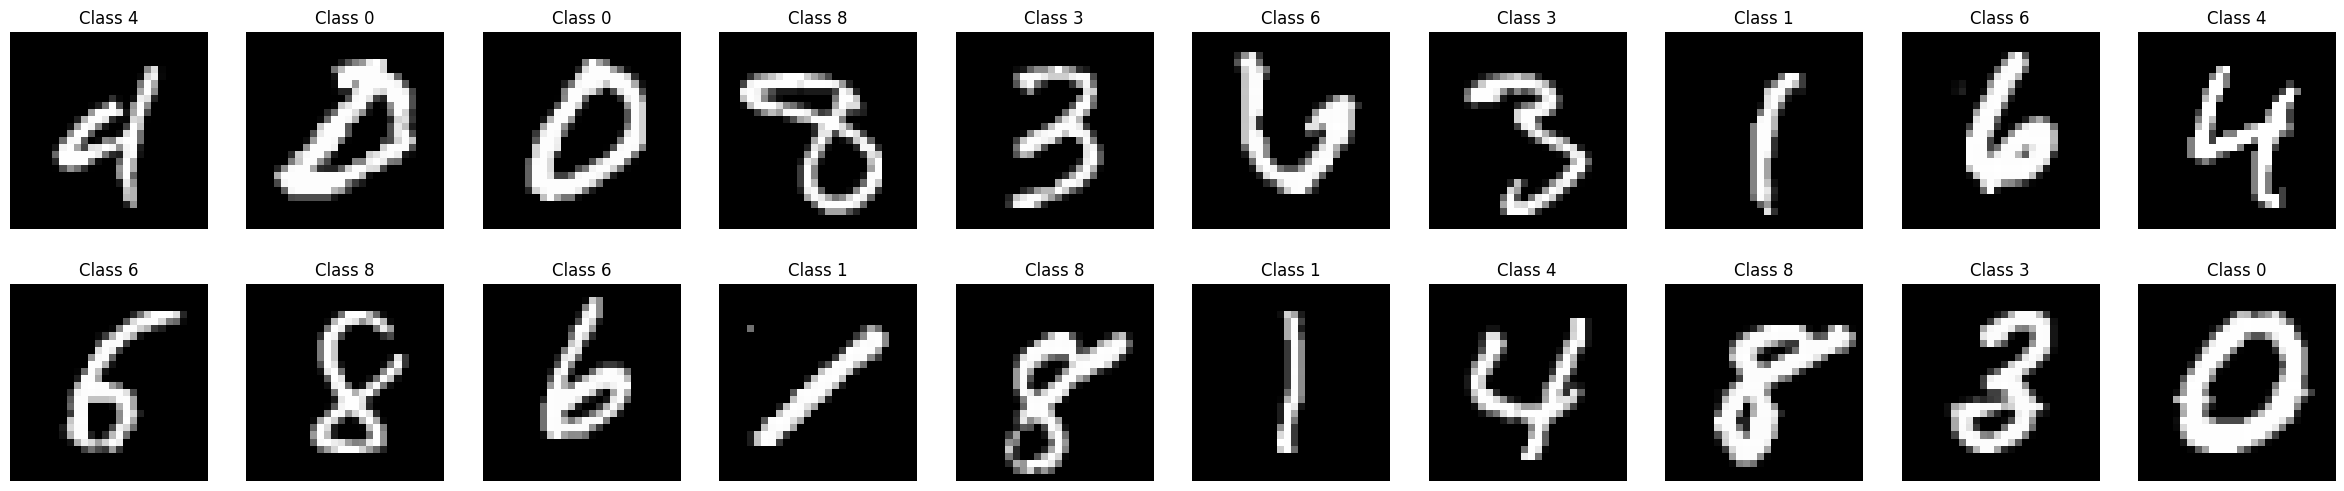

In [9]:
### esploriamo il dataset

print(f"The images are in the range [{np.min(x_train)},{np.max(x_train)}].")
n_train, w_train, h_train = x_train.shape
n_test, w_test, h_test = x_test.shape
unique_labels = np.unique(y_train)
n_classes = len(unique_labels)

# aggiungiamo la depth dell'immagine (assente per immagini grayscale)
if x_train.shape[-1] != 1:
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
print(f"The new shape of the feature matrix is: {x_train.shape}.")

# normalizziamo i dati
x_train = x_train.astype('float') / np.max(x_train)
x_test = x_test.astype('float') / np.max(x_test)
print(f"The new range of the images is [{x_train.min()},{x_train.max()}].")

fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel() # linearizziamo la matrice di axes
for i in range(20):
    rand_idx = np.random.randint(0, x_train.shape[0])
    ax[i].set_axis_off() # toglie dettagli degli assi come tick, numerazione, ecc.
    ax[i].set_title(f"Class {y_train[rand_idx]}")
    ax[i].imshow(x_train[rand_idx], vmin = x_train[rand_idx].min(), vmax = x_train[rand_idx].max(), cmap = "gray")

In [10]:
### definiamo il modello

from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

input_shape = x_train.shape[1:]
print(f"The input shape of the CNN is {input_shape}.")

model = Sequential(
    [   
        # Input layer.
        Input(shape = input_shape),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes, activation = "softmax")
    ]
)
model.summary()

The input shape of the CNN is (28, 28, 1).


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,186 (196.04 KB)

 Trainable params: 50,186 (196.04 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
### facciamo il training del modello

from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
model.compile(loss = loss_fcn,
              optimizer = opt, 
              metrics = ["accuracy"]) 

batch_size = 128
epochs = 8
val_split_percentage = 0.25
model.fit(x_train, 
          y_train, 
          batch_size = batch_size, 
          epochs = epochs, 
          validation_split = val_split_percentage);

Epoch 1/8


2025-12-13 14:11:33.989063: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 141120000 exceeds 10% of free system memory.


352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7967 - loss: 0.6829

2025-12-13 14:11:51.596675: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 47040000 exceeds 10% of free system memory.


352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.9085 - loss: 0.3130 - val_accuracy: 0.9699 - val_loss: 0.1035
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.9764 - loss: 0.0775 - val_accuracy: 0.9786 - val_loss: 0.0711
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9834 - loss: 0.0555 - val_accuracy: 0.9807 - val_loss: 0.0651
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.9868 - loss: 0.0440 - val_accuracy: 0.9827 - val_loss: 0.0609
Epoch 5/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.9893 - loss: 0.0363 - val_accuracy: 0.9832 - val_loss: 0.0588
Epoch 6/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9911 - loss: 0.0305 - val_accuracy: 0.9829 - val_loss: 0.0585
Epoch 7/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9927 - loss: 0.0257 - val_accuracy: 0.9833 - val_loss: 0.0607
Epoch 8/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9938 - loss: 0.0216 - val_accuracy: 0.98

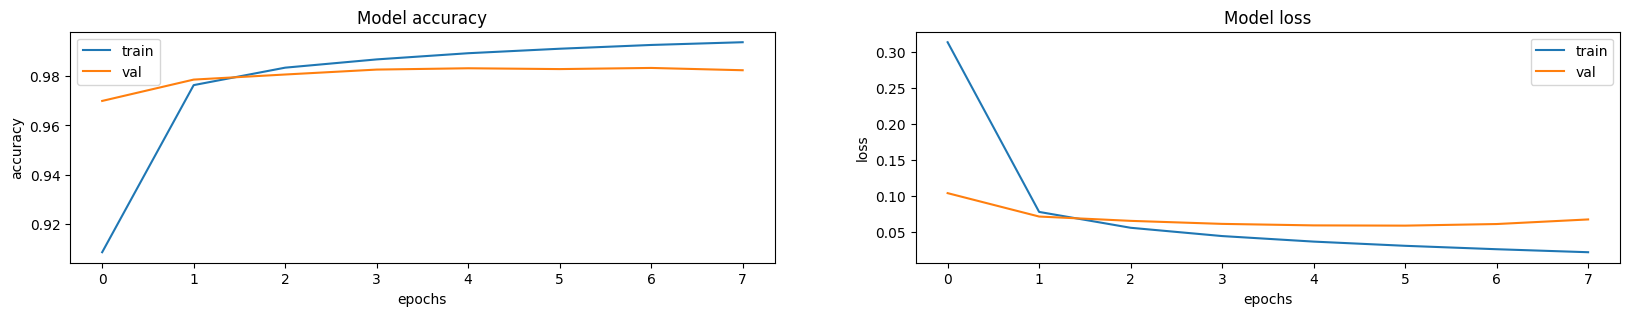

In [12]:
### valutiamo le performance

plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i+1) 
    plt.plot(model.history.history[metric])
    plt.plot(model.history.history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

# Stiamo overfittando?
no! la validation accuracy sta continuando a migliorare seppur molto piano

è probabile che se continuassimo per più epoche allora si che cominceremmo ad overfittare
- la validation accuracy rimarrebbe fissa, oppure comincerebbe addirittura a peggiorare
- mentre la training accuracy continuerebbe a salire

Il modello starebbe imparando peculiarità di questo specifico training set e non sta capendo come riconoscere immagini che non ha mai visto prima (non sta generalizzando)

In [13]:
### valutazione finale sul test set

test_loss, test_metric = model.evaluate(x_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9848 - loss: 0.0501
The test loss is 0.0501, the test accuracy is 0.9848.


In [14]:
### salviamo il modello

model.save(filepath = r'ckpts/mnist_model.keras')

## Exercise 3: Play with the parameters

Try to reimplement the code explained in the theory. Load the data, inspect it and train a new classifier changing several parameters (i.e. learning rate, optimizers, number of filters, kernel size, batch size, epochs, etc...), one at a time. 

Keep track of each parameter change and the corresponding change in model performance.
* How each parameter change affects the model performance? Why?

In [ ]:
# Write here your solution

## Exercise 4: Play with the model's architecture

Try to reimplement the code explained in the theory. Load the data, inspect it and train a new classifier changing the model's architecture (i.e. add or a convolutional layer, add more dense layers, etc...), one at a time. 

Keep track of each model change and the corresponding change in model performance.
* How each model change affects the model performance? Why?

In [ ]:
# Write here your solution

## Exercise 5 [at home]: Desing a classifier for the CIFAR10 dataset

Desing a novel classifier with the [CIFAR10 dataset](https://keras.io/api/datasets/cifar10/). Load the data, inspect it, desing and train a new classifier guiding your desing's choices with the results of the previous experiments.

*Note*: keep in mind that this is a RGB dataset.

In [1]:
# To load the data
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data();

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 62s 0us/step


In [ ]:
# Write here your solution

## Exercise 6 [at home]: Fine-tune a ResNet on a custom dataset

Create a simple custom dataset with the procedure described in the theory.
Then, load a pre-trained ResNet and test it on the custom dataset.
Next, fine-tune the pre-trained ResNet on the custom dataset and then assess the quality of the training.

In [ ]:
# Write here your solution